# Exploration of the dataset in preparation for creating a Machine Learning Model to predict star classification

## Kaggle recommended method to import dataset

In [109]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, 'Stars.csv'))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

These libraries are required to run this file, though they are not all required to run the model that is output for use in other software

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm

%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

## This section reveals information about the dataset

In [111]:
stars_data = pd.read_csv('Stars.csv')
stars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [112]:
stars_data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [113]:
stars_data.duplicated().sum()

0

*It is good to note that there is no duplicate entries; this reduces the amount of data editing that needs to occur.*

In [114]:
nan = pd.DataFrame(stars_data.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

,NaN_sum,feat,Perc(%),Usability


*This shows that there are no NaN (Not a Number) entires in numerical features. This can sometimes occur and has to be fixed prior to any data manipulation.*

## Data Inspection

This code defines the star classifications in a list. This is necessary because the way the libraries make predictions requires the classification options to be in a list format

In [115]:
stars_type = ['Red Dwarf','Brown Dwarf','White Dwarf','Main Sequence','Super Giants','Hyper Giants']
stars_data['Class'] =  stars_data['Type'].replace(stars_data['Type'].unique(),stars_type)
print(stars_data['Class'].unique())

['Red Dwarf' 'Brown Dwarf' 'White Dwarf' 'Main Sequence' 'Super Giants'
 'Hyper Giants']


### Shows the count of stars in each category

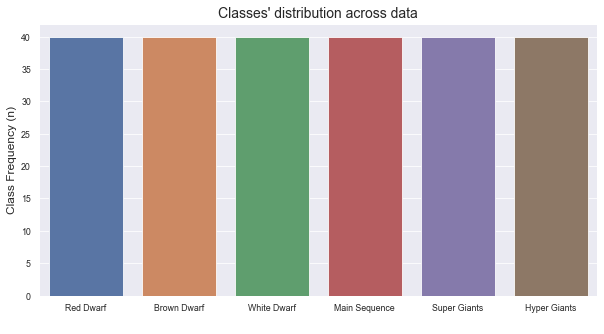

In [116]:
sns.set_theme('paper')
plt.figure(figsize = (10,5))
sns.countplot(x='Class', data = stars_data)
plt.title("Classes' distribution across data", fontsize = 14)
plt.xlabel(' ', fontsize = 12)
plt.ylabel('Class Frequency (n)', fontsize = 12)
plt.show()

#Features Description:
numerical features:

Temperature (Kelvin)
Main-sequence luminosity (L - Solar luminosity)
Main-sequence radius (R - Solar radius)
Absolute Magnitute (AM - is a measure of the luminosity of a celestial object, on an inverse logarithmic astronomical magnitude scale)

and categorical features:
Color
Spectral Class (Morgan–Keenan (MK) system using the letters: O (hottest),B,A,F,G,K,M (coldest))
Type (Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , Super Giants, Hyper Giants)

### Data correction

In [117]:
stars_data['Color'].loc[stars_data['Color'] =='Blue-white'] = 'Blue-White'
stars_data['Color'].loc[stars_data['Color'] =='Blue White'] = 'Blue-White'
stars_data['Color'].loc[stars_data['Color'] =='Blue white'] = 'Blue-White'
stars_data['Color'].loc[stars_data['Color'] =='yellow-white'] = 'White-Yellow'
stars_data['Color'].loc[stars_data['Color'] =='Yellowish White'] = 'White-Yellow'
stars_data['Color'].loc[stars_data['Color'] =='white'] = 'White'
stars_data['Color'].loc[stars_data['Color'] =='yellowish'] = 'Yellowish'

*The Color feature, on inspection, had variations in spelling that needed corrected before continuing.*

### Data Inspection

This section investigates the data from a statistical viewpoint; this knowledge can be used to help determine when models over or under fit.

In [118]:
stars_data.describe()

,Temperature,L,R,A_M,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


This graph imposes what would be a normal data distributino in black, and shows a density estimate as well as the maximum likeliehood distribution.

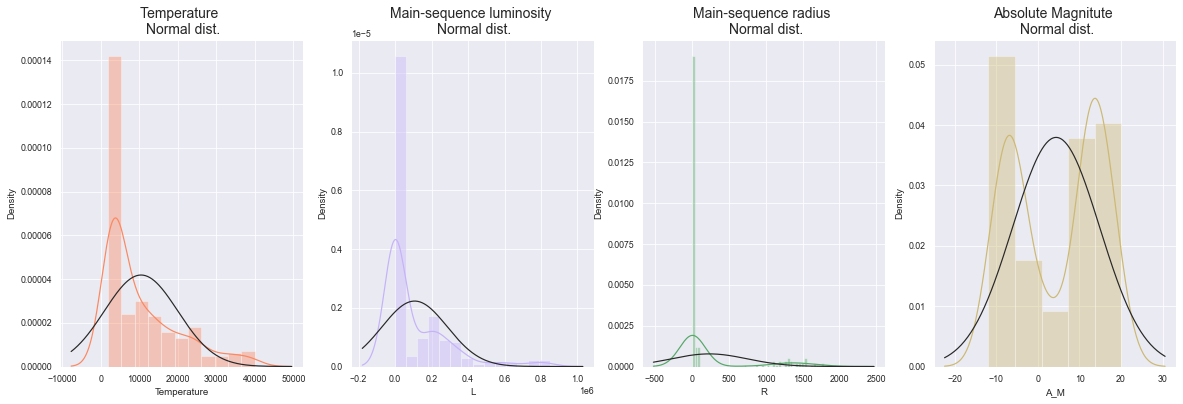

In [119]:
f, ax = plt.subplots(1,4, figsize = (20,6))

sns.distplot(stars_data['Temperature'],fit=norm, color='#FB8861', ax = ax[0])
ax[0].set_title('Temperature \n Normal dist.', fontsize=14)

sns.distplot(stars_data['L'],fit=norm, color='#C5B3F9', ax = ax[1])
ax[1].set_title('Main-sequence luminosity \n Normal dist.', fontsize=14)

sns.distplot(stars_data['R'],fit=norm,color='g', ax = ax[2])
ax[2].set_title('Main-sequence radius \n Normal dist.', fontsize=14)

sns.distplot(stars_data['A_M'],fit=norm, color='y', ax = ax[3])
ax[3].set_title('Absolute Magnitute \n Normal dist.', fontsize=14)

plt.show()

This graph is a box plot. The box is the interquartile range. The lower box is the 25th percentile, the higher is 75%. The whiskers are calculated to catch data below the 25th percentile and over the 75th percentile, but allows anything too far out to be considered an outlier. This is used to clearly see the range of values rather than displaying the count of data points.

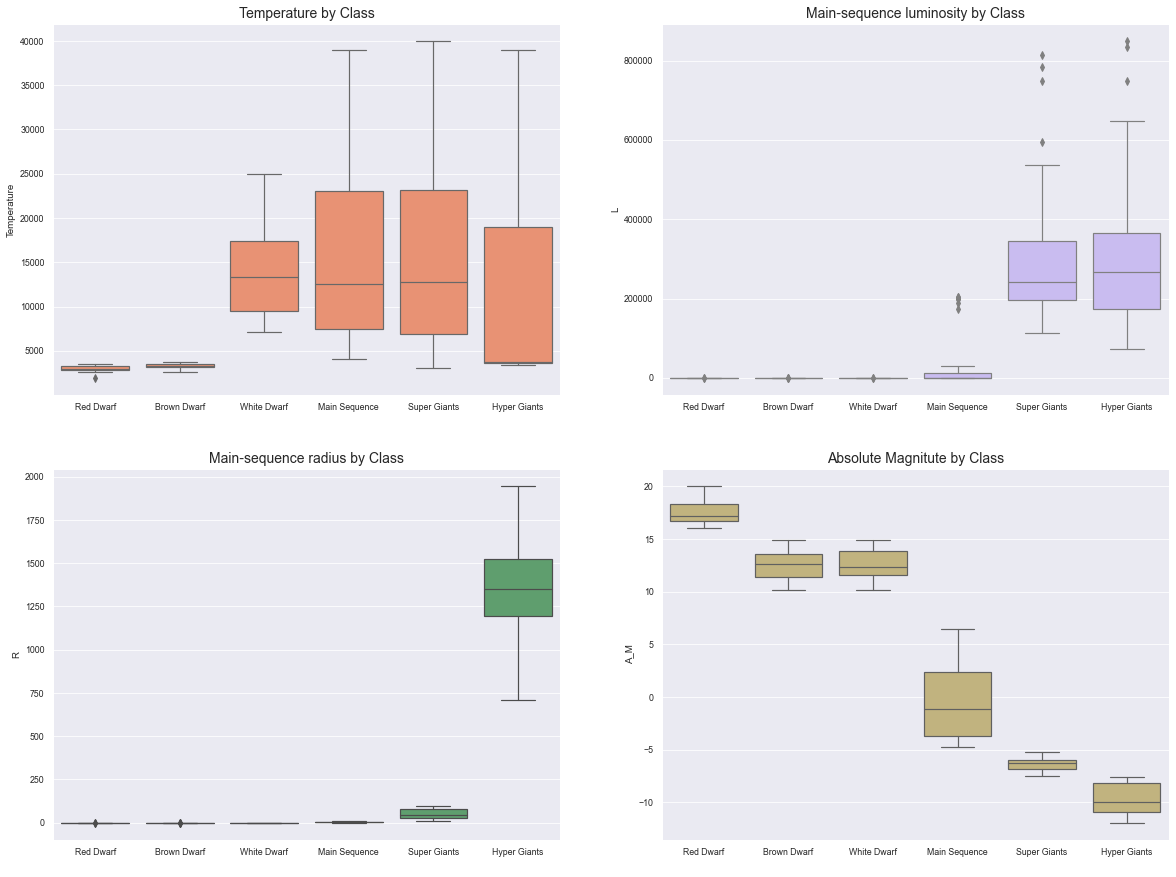

In [120]:
# Looking at our numerical features' descriptive aspects 
f, ax = plt.subplots(2,2, figsize = (20,15))

sns.boxplot(x = stars_data['Class'], y = stars_data['Temperature'], color='#FB8861', ax = ax[0][0])
ax[0][0].set_title('Temperature by Class', fontsize=14)
ax[0][0].set_xlabel(' ')

sns.boxplot(x = stars_data['Class'], y = stars_data['L'], color='#C5B3F9', ax = ax[0][1])
ax[0][1].set_title('Main-sequence luminosity by Class', fontsize=14)
ax[0][1].set_xlabel(' ')

sns.boxplot(x = stars_data['Class'], y = stars_data['R'], color='g', ax = ax[1][0])
ax[1][0].set_title('Main-sequence radius by Class', fontsize=14)
ax[1][0].set_xlabel(' ')

sns.boxplot(x = stars_data['Class'], y = stars_data['A_M'], color='y', ax = ax[1][1])
ax[1][1].set_title('Absolute Magnitute by Class', fontsize=14)
ax[1][1].set_xlabel(' ')

plt.show()

The heatmap evaluates the linear relationship between two features. Negative means one variable decreases as another increases. Positive means both increase at the same time. The closer a value is to 0, the less likely it is for there to be linear relationship.

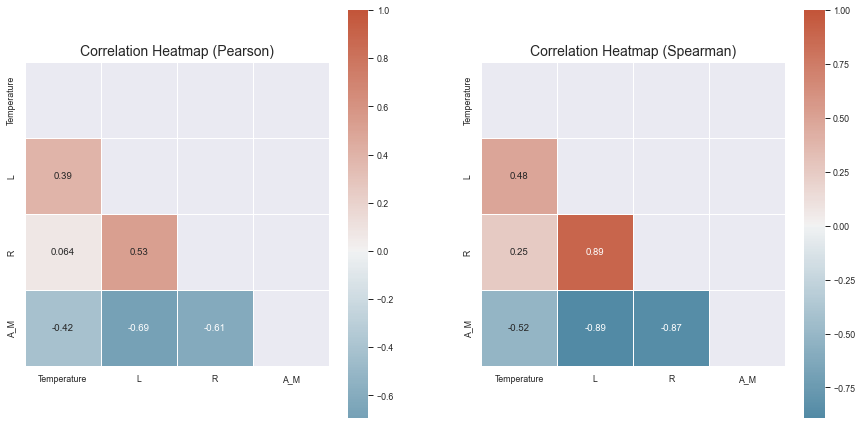

In [121]:
# Correlation Heatmaps (Pearson - Spearman)

f, ax = plt.subplots(1,2, figsize=(15, 15))

mat_p = stars_data.drop('Type', axis = 1).corr('pearson')
mat_s = stars_data.drop('Type', axis = 1).corr('spearman')

mask_p = np.triu(np.ones_like(mat_p, dtype=bool))
mask_s = np.triu(np.ones_like(mat_s, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(mat_p, mask=mask_p, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax = ax[0])
ax[0].set_title('Correlation Heatmap (Pearson)', fontsize = 14)

sns.heatmap(mat_s, mask=mask_s, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax = ax[1])
ax[1].set_title('Correlation Heatmap (Spearman)', fontsize = 14)

plt.show()

The pairplot graphs each feature against each feature. The diagonal looks a tad strange because that is where the feature is graphed against itself.

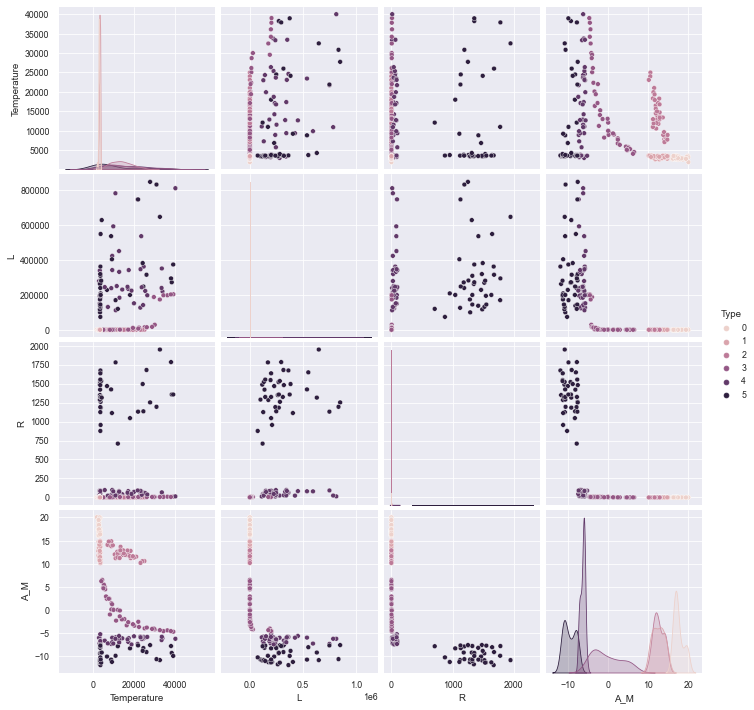

In [122]:
sns.pairplot(data=stars_data,hue="Type")
plt.show()

### Data manipulation

I decided to remove the outliers because they are statistically unlikely and could skew the model. Figuring out how to remove it took far too long.

In [123]:
def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' number of outliers deleted: {}'.format(len(outliers)))
    #print(feature_name + ' outliers:{}'.format(outliers))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset


data_cleaned = outliers_removal(stars_data['L'],'L', stars_data)

Quartile 25: 0.0008647500000000001 | Quartile 75: 198050.0
iqr: 198049.99913525
Cut Off: 297074.998702875
L Lower: -297074.997838125
L Upper: 495124.998702875
L number of outliers deleted: 12
-----------------------------------------------------------------


This creates two lists made of the original data - either the number or categorical data. This makes it easier to do manipulations meant for either text or numbers.

In [124]:
num_feat = stars_data.drop(['Color','Spectral_Class','Type','Class'], axis = 1)
cat_feat = stars_data.drop(['Temperature','L','R','A_M','Type','Class'], axis = 1)

The get_dummies function converts the categories within a column into features, and uses 0 and 1 as flags to determine where the values are true or false.

In [125]:
data_dummy = pd.get_dummies(cat_feat)
data_dummy.head()

,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale yellow orange,Color_Red,Color_White,Color_White-Yellow,Color_Whitish,Color_Yellowish,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


The MinMaxScaler scales the features to fit between 0 and 1. This is more convenient both for human and computer understanding.

In [126]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(num_feat)
data_scaled = pd.DataFrame(data_scaled, columns = num_feat.columns)
data_scaled.head()

,Temperature,L,R,A_M
0,0.029663,2.731275e-09,0.000083,0.876798
1,0.028980,4.944550e-10,0.000075,0.891807
2,0.017367,2.590003e-10,0.000048,0.957473
3,0.022622,1.412729e-10,0.000078,0.893371
4,0.000000,6.828189e-11,0.000049,1.000000


With the scaling done, the dataset is now recombined.

In [127]:
data_complete = data_scaled.join(data_dummy)
data_complete.head()

,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale yellow orange,Color_Red,...,Color_White-Yellow,Color_Whitish,Color_Yellowish,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,0.029663,2.731275e-09,0.000083,0.876798,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.028980,4.944550e-10,0.000075,0.891807,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0.017367,2.590003e-10,0.000048,0.957473,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0.022622,1.412729e-10,0.000078,0.893371,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0.000000,6.828189e-11,0.000049,1.000000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## Machine Learning Modeling Process

### Creating a training and testing set

The training set is used to train the model; the test set is used for **final** evaluation. The first line takes the complete data and labels (classification), and divides the data. The train objects hold .9, or 90%, of the dataset. the test objects hold .1, or 10%. This is acceptable because much training data is required for training, and a comparatively small amount of data is necessary to evaluate whether or not it was successful. The stratify argument provides the labels (classifications). Shuffle randomizes how the data will be split, to prevent training bias if the data is sorted.

In [128]:
from sklearn.model_selection import train_test_split

# Defining our labels

labels = stars_data['Class']

# Splitting the data

Xtrain,X_test,ytrain,y_test = train_test_split(data_complete,labels,
                                               test_size = 0.1,
                                               stratify = labels,
                                               shuffle = True)


X_train,X_val,y_train,y_val = train_test_split(Xtrain,ytrain,
                                               test_size = 0.1,
                                               stratify = ytrain,
                                               shuffle = True)

### Creating a model

These imports are for convenience. Some that are still here are no longer in use because I later decided against using the relevant model. It isn't necessary to clean this up because this file will not be used by other software.

In [129]:
import sklearn
from sklearn import tree
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

I decided on using the logistic regression model. It is simplistic, but this dataset is very straightforward. The heatmaps showed linear relationships between several features, and I anticicpate that will make creating a model straightforward. 

In [130]:
l_reg = LogisticRegression(random_state = 42)
log_model = l_reg.fit(X_train,y_train)
pred = log_model.predict(X_val)

print(classification_report(y_val, pred, target_names = stars_data['Class'].unique()))

               precision    recall  f1-score   support

    Red Dwarf       0.80      1.00      0.89         4
  Brown Dwarf       1.00      1.00      1.00         4
  White Dwarf       1.00      0.67      0.80         3
Main Sequence       1.00      1.00      1.00         3
 Super Giants       0.75      0.75      0.75         4
 Hyper Giants       1.00      1.00      1.00         4

     accuracy                           0.91        22
    macro avg       0.92      0.90      0.91        22
 weighted avg       0.92      0.91      0.91        22



*The model is 91% accurate out of the box. This may be due to overfitting, but considering what I noted above, and the removal of outliers, I doubt it.*

## Exporting the model

Below is a class that does the necessary data transformations to the original dataset. This class is used to create an object that takes in the original datset and outputs the original dataset with the labels chagned to the predictions.

In [131]:
#pip install pandas
#pip install scikit-learn
#pip install pickle

import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import datasets
import pickle
from joblib import dump, load

class FinalModel():
    
    def outliers_removal2(self, feature,feature_name,dataset):
        q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
        feat_iqr = q75 - q25
    
        feat_cut_off = feat_iqr * 1.5
        feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off

        outliers = [x for x in feature if x < feat_lower or x > feat_upper]
        #print(feature_name + ' outliers:{}'.format(outliers))
        dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
        return dataset

    def predict(self, dataset):
        stars_type = ['Red Dwarf','Brown Dwarf','White Dwarf','Main Sequence','Super Giants','Hyper Giants']
        stars_data['Class'] =  stars_data['Type'].replace(stars_data['Type'].unique(),stars_type)
        stars_data['Color'].loc[stars_data['Color'] =='Blue-white'] = 'Blue-White'
        stars_data['Color'].loc[stars_data['Color'] =='Blue White'] = 'Blue-White'
        stars_data['Color'].loc[stars_data['Color'] =='Blue white'] = 'Blue-White'
        stars_data['Color'].loc[stars_data['Color'] =='yellow-white'] = 'White-Yellow'
        stars_data['Color'].loc[stars_data['Color'] =='Yellowish White'] = 'White-Yellow'
        stars_data['Color'].loc[stars_data['Color'] =='white'] = 'White'
        stars_data['Color'].loc[stars_data['Color'] =='yellowish'] = 'Yellowish'
        data_cleaned = self.outliers_removal2(stars_data['L'],'L', dataset)
        num_feat = stars_data.drop(['Color','Spectral_Class','Type','Class'], axis = 1)
        cat_feat = stars_data.drop(['Temperature','L','R','A_M','Type','Class'], axis = 1)
        data_dummy = pd.get_dummies(cat_feat)
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(num_feat)
        data_scaled = pd.DataFrame(data_scaled, columns = num_feat.columns)
        data_complete = data_scaled.join(data_dummy)
        labels = stars_data['Class']

        # Splitting the data

        Xtrain,X_test,ytrain,y_test = train_test_split(data_complete,labels,
                                                    test_size = 0.1,
                                                    stratify = labels,
                                                    shuffle = True)


        X_train,X_val,y_train,y_val = train_test_split(Xtrain,ytrain,
                                                    test_size = 0.1,
                                                    stratify = ytrain,
                                                    shuffle = True)
        l_reg = LogisticRegression(random_state = 42)
        log_model = l_reg.fit(X_train,y_train)
        pred = log_model.predict(data_complete)
        stars_data['Class'] = pred
        stars_data.to_csv("Star_data_with_predictions.csv")
        
    

FinalModel3 = FinalModel()

In [132]:
FinalModel3.predict(stars_data)

In [133]:
dump(FinalModel3, 'Star_Predict.joblib')

['Star_Predict.joblib']

In [134]:
#pip install pandas
#pip install scikit-learn
#pip install pickle

#import pandas as pd
#rom sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
#from sklearn.linear_model import LogisticRegression
#from sklearn import svm
#from sklearn import datasets
#import pickle

FinalModel3 = load('Star_Predict.joblib')
FinalModel3 = FinalModel3.predict(stars_data)